# `mosaictools` package demonstration

This jupyter notebook demonstrates the usage and performance of the `mosaictools` Python package.

The module implements a novel approach to Surrogate Modelling of Modal Properties, called Mode-Shape-Adapted Input Parameter Domain Cutting ([MOSAIC](https://doi.org/10.2139/ssrn.5072693))

## 1. Installing the package

The `mosaictools` package can be found here on the PyPI platform: [https://pypi.org/project/mosaictools/](https://pypi.org/project/mosaictools/)

One can install the package using `pip`, with the terminal command `pip install mosaictools` or by executing the cell below:

In [ ]:
! pip install mosaictools

The `mosaictools` library uses external modules for calculation, such as `numpy` or `scikit-learn`.

Our module requires `numpy<2.0` at the moment, due to the most recent versions are not yet compatible with other external modules. Consider downgrading with command `pip install numpy<2.0` if needed, or by excecuting the cell below:

In [ ]:
! pip install "numpy<2.0"

## 2. Importing modules

In [ ]:
import mosaictools as mosaic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
mosaic.__version__

'0.1.11'

## 3. Defining MOSAIC model

Surrogate modelling of modal properties is particularly challenging due to the mode degeneration phenomena, such as mode crossing, veering, and coalescence. MOSAIC gives a novel approach to surrogate modelling of modal properties that is accurate and reduces the required number of training points. Detailed explenation of the method is presented in the following preprint: [https://doi.org/10.2139/ssrn.5072693](https://doi.org/10.2139/ssrn.5072693)

The here-introduced mode-shape-adapted input parameter domain cutting (MOSAIC) surrogate modelling technique is a form of piecewise approximation. The novelty of this approach lies in the intelligent cutting of the parameter domain into subdomains, which identifies regions where the mode shapes smoothly change. A trained MOSAIC model takes parameter values as inputs and returns natural frequencies and eigenvectors.

Before training, one should define the model by giving information about the names and bounds of the parameters in the following format: list of strings and list of tuples. The MOSAIC model only handles parameters with uniform distribution.

This notebook shows the usage of the mosaictools library with the example of a bridge (illustration below). The following input parameters were chosen for this MOSAIC model:

- $E_{steel}$ - the elastic modulus of steel in linear scale between 1.9e5 MPa and 2.1e5 MPa
- $t_{slab}$ - the thickness of the concrete slab in linear scale between 360 mm and 440 mm
- $k_{found}$ - spring stiffness in the vertical direction with a logarithmic scale between 1e5 N/mm and 1e7 N/mm 

![alt text](bridge_figure.png)

The parameter values are projected between bounds [-1, 1] in this example.

In [5]:
parameter_names = ['E_steel', 't_slab', 'k_found']
parameter_bounds = [(-1, 1), (-1, 1), (-1, 1)]

### 3.1 Default settings

Using the parameter informations, one can define a MOSAIC model with the default settings the following way.

In [6]:
model = mosaic.Mosaic(parameter_names, parameter_bounds)

Further arguments with the default values are the following:

- `max_freq_degree` = 4

Maximal degree of approximation of the natural frequency models. Used in gPCE models.


- `max_vect_degree` = 5

Maximal degree of approximation of the eigenvector models. Used in gPCE models.


- `resolution` = 0.6

Threshold for the highest allowed correlation between reference eigenvectors (similar to cluster centers). Used in the parameter domain cutting process.


- `classification_method` = 'svc'

Type of the SubdomainClassifier. With the 'svc' setting the model uses the C-Support Vector Classification (SVC) classifier of the `sklearn.svm` module.

- `**classifier_kwargs`

Arbitrary keyword arguments for setting the classifier with the chosen method.

### 3.2 Advanced settings

#### 3.2.1 Approximation degree

The MOSAIC freamework builds separate natural frequency and eigenvector models for each subdomain of the modes. For surrogating, generalized Polynomial Chaos Expansion (gPCE) models are used, approximating the modal properties as linear combination of multidimensional polynomials.

One can separately set the maximal degrees of approximations of the polynomials in the two types of the modal properties with arguments `max_freq_degree` and `max_vect_degree`. 

In [7]:
model = mosaic.Mosaic(parameter_names, parameter_bounds, max_freq_degree=8, max_vect_degree=8)

#### 3.2.2 Resolution

The subdomain splitting in the MOSAIC model is done by a hierarchical clustering method on the train eigenvectors. The procedure results eigenvector sets with high pairwise correlations within each set, providing smooth response surfaces for the gPCE models. A cluster is identified by its reference eigenvector. The reference eigenvector is an element of the cluster with the smallest distance from the cluster's centroid.

The number of subdomains is controlled by the `resolution` hyperparameter, that sets the maximum allowed correlation between two reference eigenvectors.

A higher resolution results in finer MOSAIC model, smaller subdomains with reduced variance, allowing lower degree polynomial approximations.

In [8]:
model = mosaic.Mosaic(parameter_names, parameter_bounds, resolution=0.9)

#### 3.2.3 Classifier settings

In the MOSAIC framework each mode has its own Subdomain Classifier trained on the parameter values labeled by the reference eigenvectors of the subdomains. The supervised classification algorithm splits the parameter domain into subdomains separated by boundary surfaces. The purpose of this classifier is to accurately assign any new parameter point to the correct subdomain, thereby selecting the appropriate local model for predicting the modal properties.

The default supproted classifier type in MOSAIC is the SVC classifier of `sklearn.svm`. After choosing the method with `classification_method='svc'`, it is possible to set every hyperparameter of the SVC with keyword arguments given separately, or with a dictionary.

In [9]:
model = mosaic.Mosaic(parameter_names, parameter_bounds, classification_method='svc', gamma='scale', kernel='poly', max_iter=-1, coef0=3, degree=5, probability=True)

In [10]:
classifier_parameters = {
    'gamma': 'scale',
    'kernel': 'poly',
    'max_iter': -1,
    'coef0': 3,
    'degree': 5,
    'probability': True
}

model = mosaic.Mosaic(parameter_names, parameter_bounds, classification_method='svc', **classifier_parameters)

#### 3.2.4 Custom classifier

MOSAIC leaves the opportunity of using other classification methods by selecting `classification_method='custom'` and adding an instance of the classifier model as the `classifier_model` argument.

Any classifier model is supported with the following implemented methods:

- fit(X, y)

- predict(X)

- predict_proba(X)

- score(X, y)

In [11]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
model = mosaic.Mosaic(parameter_names, parameter_bounds, classification_method='custom', classifier_model=classifier)

## 4. Loading training data

For the training of an initialized model, parameter values with corresponding natural frequencies and eigenvectors are needed. The modal properties are usually given from a finite element (FE) model, outside of the MOSAIC framework.

A model instance provides the possibility of sampling from the parameters with the `.sample()` method. The method gives back the desired number of parameter samples using Halton sampling. These samples can be used as inputs of the FE model.

In [12]:
sampled_parameters = model.sample(5000)
print(sampled_parameters.shape)

(5000, 3)


TODO: Some descriptions

In [13]:
parameters = np.load('mosaic_example_data/parameters.npy')
print("Parameters: {}".format(parameters.shape))

frequencies = np.load('mosaic_example_data/frequencies.npy')
print("Eigenfrequencies: {}".format(frequencies.shape))

eigenvectors = np.load('mosaic_example_data/eigenvectors.npy')
print("Eigenvectors: {}".format(eigenvectors.shape))

Parameters: (5000, 3)
Eigenfrequencies: (5000, 10)
Eigenvectors: (5000, 10, 2241)


## 5. Training the model

The training of an existing MOSAIC model is executed with the `.fit()` method. It is a strongly data-driven process, because the number of modes and the regression, clustering and classification steps are highly depends on the modal properties.

The method takes the `parameters`, `frequencies` and `eigenvectors` arrays as training data with the following structure:
- parameters: (#samples, #parameters)
- frequencies: (#samples, #modes)
- eigenvectors: (#samples, #modes, #vector_nodes)

By setting argument `verbose=True`, one can follow the training process mode by mode.

Without further information about the model, the training is shown with the default settings at this point, except for the classifier. Hyperparameter optimization and the training of a more accurate model is shown later for comparison.

The training process could take some time depending on the number of datapoints and modes (~1 minute in this example).

In [14]:
model = mosaic.Mosaic(parameter_names, parameter_bounds, classification_method='svc', gamma='scale', kernel='poly', max_iter=-1, coef0=3, degree=5, probability=True)
model.fit(parameters, frequencies, eigenvectors, verbose=True)

Number of modes: 10
Mode 1 is trained
Mode 2 is trained
Mode 3 is trained
Mode 4 is trained
Mode 5 is trained
Mode 6 is trained
Mode 7 is trained
Mode 8 is trained
Mode 9 is trained
Mode 10 is trained


## 6. Cross-validating the model

Cross-validation is a technique used to assess how well a machine learning model generalizes to new, unseen data. It involves splitting the data into multiple subsets (folds), training the model on some folds, and evaluating it on the remaining fold, repeating this process multiple times to get a more robust estimate of performance. Instead of using a single train/test split, cross-validation uses multiple splits to evaluate the model's performance on different portions of the data.

A k-fold cross-validation is implemented in the `.cross_validate()` method, where the data is equally divided into `k` subsets. In each iterations one of the slices is used as validation set and the model is trained on the remaining `k-1`. The model predicts the natural frequqncies and the eigenvectors from the parameters of the validation set and calculates the error between the predicted and the validation properties. The method returns the total error across all folds, providing information about the overall mperformance of the model.

Metrics used for the error calculation:

- Frequencies: Relative Frequency Error (absolute difference between the two frequencies divided by the real frequency value)

- Eigenvectors: MAC Error (1 - MAC value between the two vectors)

The method waits for the initialized model and the total training sets of the `parameters`, `frequencies` and `eigenvectors`. `n_folds` sets the number of cross-validation folds (9 by default), `shuffle=True` randomly reorders the data and with `verbose=True` the finished steps are printed out during the validation.

Since cross-validation repeatedly retrains the model, the whole process could take some time, depending on the training data and the number of folds (~11 minutes in this example).

In [15]:
freq_errors, eigenvector_errors = mosaic.cross_validate(model, parameters, frequencies, eigenvectors, n_folds=9, shuffle=False, verbose=True)

Cross-validation started. The process may take a couple minutes
1/9 fold is done
2/9 folds are done
3/9 folds are done
4/9 folds are done
5/9 folds are done
6/9 folds are done
7/9 folds are done
8/9 folds are done
9/9 folds are done


The following plot shows the Relative Frequency Error and the MAC Error results of the cross-validation, mode by mode.

Boxes are drawn between the 25th and 75th percentiles of the errors with the median line inside. The whiskers are drawn between the 5th and 95th percentiles and the outliers are shown with circles.

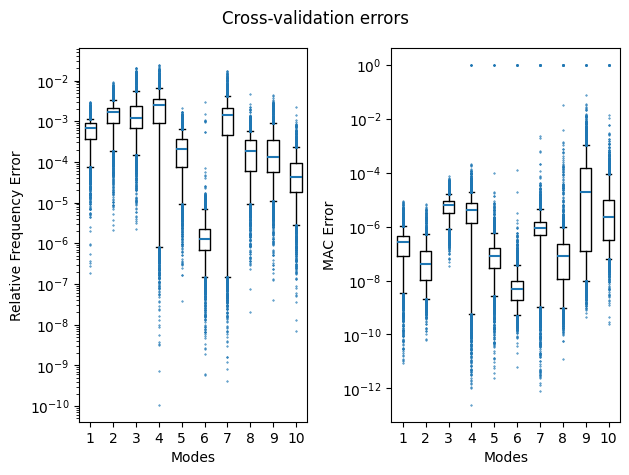

In [16]:
fig, axes = plt.subplots(1, 2)

flierprops = dict(marker='.', markerfacecolor='none', markersize=1,
                  linestyle='none', markeredgecolor='C0')
medianprops=dict(color ="C0", linewidth= 1.5)
axes[0].boxplot(freq_errors, showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
axes[0].set_xlabel('Modes')
axes[0].set_ylabel('Relative Frequency Error')
axes[0].set_yscale('log')

axes[1].boxplot(eigenvector_errors, showfliers = True,  whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
axes[1].set_xlabel('Modes')
axes[1].set_ylabel('MAC Error')
axes[1].set_yscale('log')
fig.suptitle('Cross-validation errors')

fig.tight_layout()

## 7. Using the model

The model can be used for prediction after the training with the `.predict()` method. The model provides the predicted modal properties of the given parameter values. Predicting from one or multiple samples is possible, as shown in the following cells.

In [17]:
sampled_parameter = model.sample(1)
print("Parameter sample: {}".format(sampled_parameter.shape))

predicted_frequencies, predicted_eigenvectors = model.predict(sampled_parameter)

print("Predicted eigenfrequencies: {}".format(predicted_frequencies.shape))
print("Predicted eigenvectors: {}".format(predicted_eigenvectors.shape))

Parameter sample: (1, 3)
Predicted eigenfrequencies: (1, 10)
Predicted eigenvectors: (1, 10, 2241)


In [18]:
sampled_parameters = model.sample(1000)
print("Parameter samples: {}".format(sampled_parameters.shape))

predicted_frequencies, predicted_eigenvectors = model.predict(sampled_parameters)

print("Predicted eigenfrequencies: {}".format(predicted_frequencies.shape))
print("Predicted eigenvectors: {}".format(predicted_eigenvectors.shape))

Parameter samples: (1000, 3)
Predicted eigenfrequencies: (1000, 10)
Predicted eigenvectors: (1000, 10, 2241)


## 8. Optimising the model

Finding the optimal hyperparameter setting is crucial for building an accurate MOSAIC model. However, because of the data-driven nature of the model, finding the optimal setting can be difficult.

An example for the model optimization is shown below. At first, we are looking for the previous model's optimal `resolution` value from the followings: 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95 and 0.975. In each step, the model is initialized with one of the values, cross-validated and the errors are saved for comparison.

Repetedly cross-validating the model is an expensive process. In this demonstration we used only the 40% of the data and cross-validated in 5 folds, to make the procedure quicker (~6 minutes in this example). Using more folds and the whole data would show a more accurate behaviour of the model.

In [19]:
resolutions = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975]

total_freq_errors = np.zeros((2000, 10, len(resolutions)))
total_vect_errors = np.zeros((2000, 10, len(resolutions)))

for i in range(len(resolutions)):
    print('Resolution: {}'.format(resolutions[i]))
    model = mosaic.Mosaic(parameter_names, parameter_bounds, resolution=resolutions[i], classification_method='svc', gamma='scale', kernel='poly', max_iter=-1, coef0=3, degree=5, probability=True)
    freq_errors, eigenvector_errors = mosaic.cross_validate(model, parameters[:2000, :], frequencies[:2000, :], eigenvectors[:2000, :, :], n_folds=5, shuffle=False, verbose=True)
    total_freq_errors[:, :, i] = freq_errors
    total_vect_errors[:, :, i] = eigenvector_errors

Resolution: 0.3
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Resolution: 0.4
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Resolution: 0.5
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Resolution: 0.6
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Resolution: 0.7
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Resolution: 0.8
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done


The following plot shows the cross-validation errors with the different resolution values.

Text(0.5, 0.98, 'Cross-validation errors of the different resolution settings by mode')

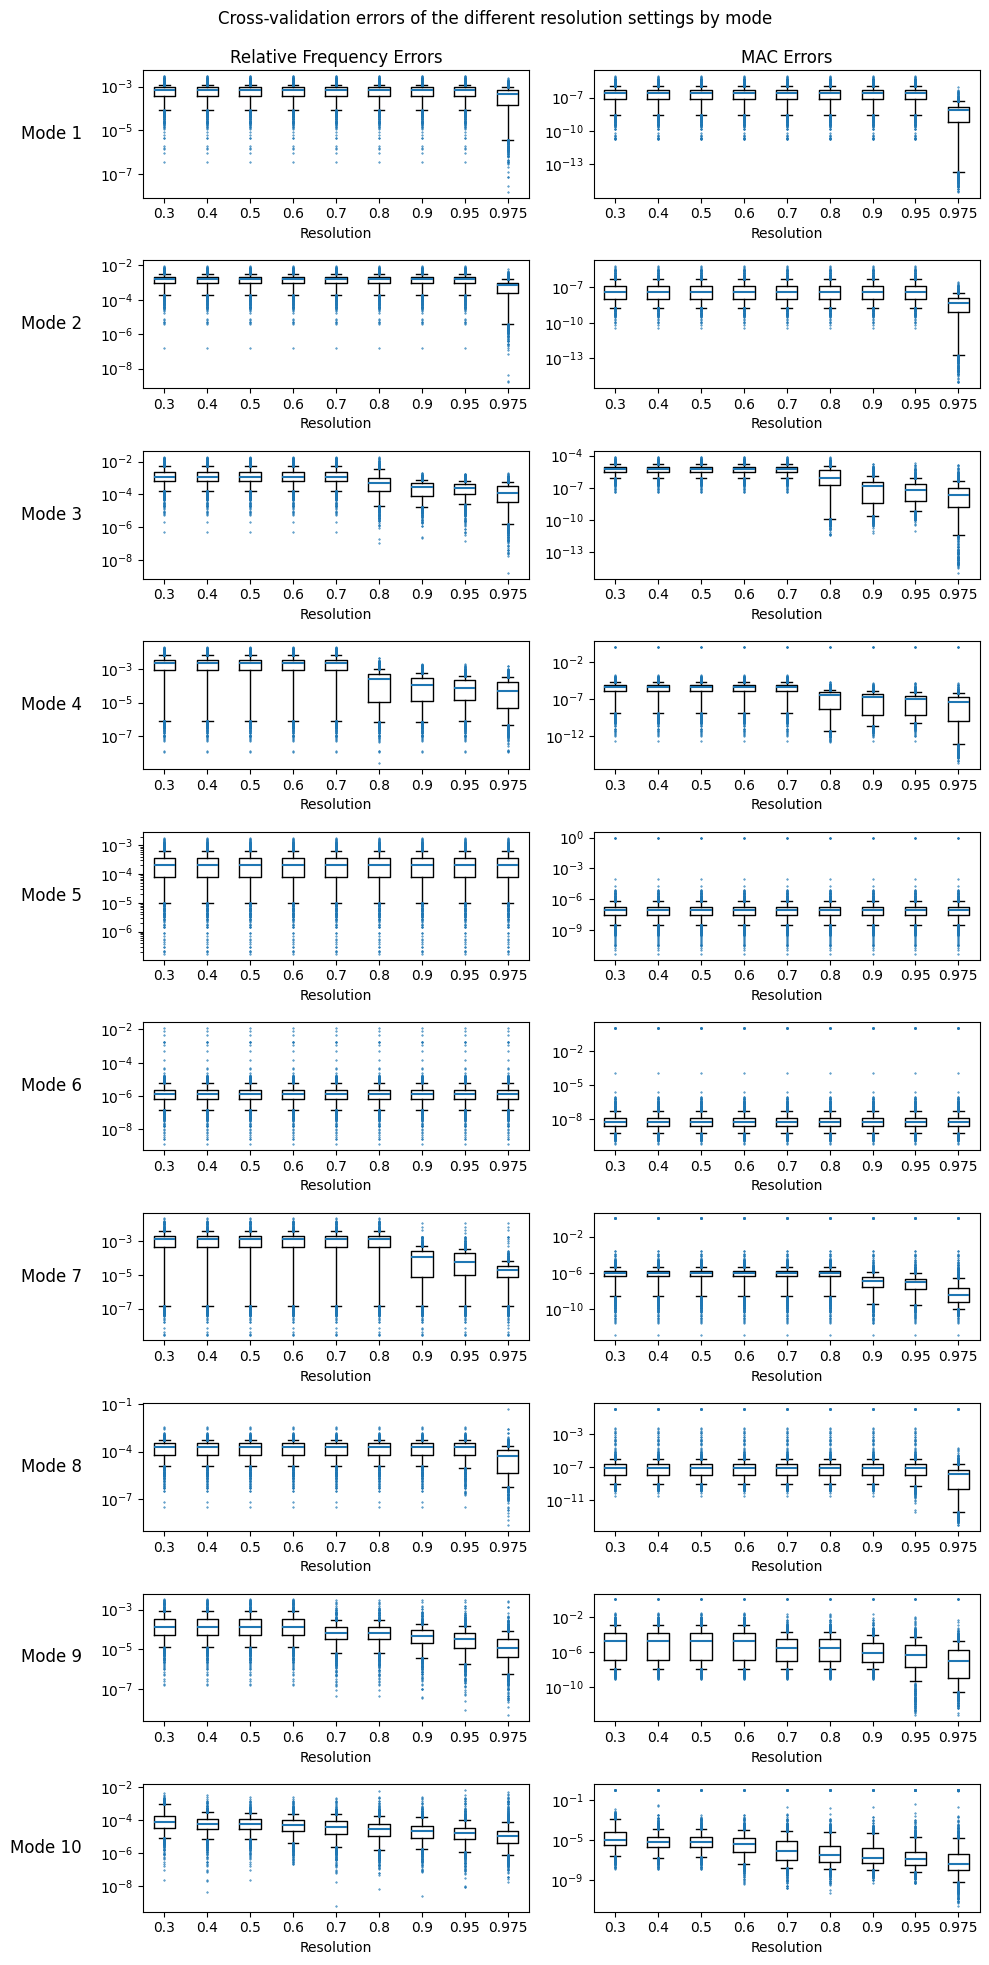

In [20]:
fig, ax = plt.subplots(10, 2, figsize=(10, 20))
flierprops = dict(marker='.', markerfacecolor='none', markersize=1,
                  linestyle='none', markeredgecolor='C0')
medianprops=dict(color ="C0", linewidth= 1.5)

cols = ['Relative Frequency Errors', 'MAC Errors']
pad = 5


for axes, col in zip(ax[0], cols):
    axes.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for i, axes in enumerate(ax[:, 0]):
    axes.annotate('Mode {}'.format(i+1), xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),
                xycoords=axes.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for i in range(10):
    ax[i, 0].boxplot(total_freq_errors[:, i, :], showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
    ax[i, 0].set_xlabel('Resolution')
    ax[i, 0].set_xticklabels(resolutions)
    ax[i, 0].set_yscale('log')

    ax[i, 1].boxplot(total_vect_errors[:, i, :], showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
    ax[i, 1].set_xlabel('Resolution')
    ax[i, 1].set_xticklabels(resolutions)
    ax[i, 1].set_yscale('log')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Cross-validation errors of the different resolution settings by mode')


`resolution=0.975` provided the lowest errors in total, so we continue the model optimization using this setting. For finding the optimal degrees of approximation, we repeat the process for `max_freq_degree` and `max_vect_degree` between values 2 and 16 (~23 minutes in this example).

In [22]:
total_freq_errors_degree = np.zeros((2000, 10, 15))
total_vect_errors_degree = np.zeros((2000, 10, 15))

for i in range(15):
    print('Max. degree of approximation: {}'.format(i+2))
    model = mosaic.Mosaic(parameter_names, parameter_bounds, max_freq_degree=i+2, max_vect_degree=i+2, resolution=0.975, classification_method='svc', gamma='scale', kernel='poly', max_iter=-1, coef0=3, degree=5, probability=True)
    freq_errors, eigenvector_errors = mosaic.cross_validate(model, parameters[:2000, :], frequencies[:2000, :], eigenvectors[:2000, :, :], n_folds=5, shuffle=False, verbose=True)
    total_freq_errors_degree[:, :, i] = freq_errors
    total_vect_errors_degree[:, :, i] = eigenvector_errors

Max. degree of approximation: 2
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Max. degree of approximation: 3
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Max. degree of approximation: 4
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Max. degree of approximation: 5
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Max. degree of approximation: 6
Cross-validation started. The process may take a couple minutes
1/5 fold is done
2/5 folds are done
3/5 folds are done
4/5 folds are done
5/5 folds are done
Max. degree of approximation: 7
Cross-validation starte

The following plot shows the cross-validation errors with the different max. degrees of approximation

Text(0.5, 0.98, 'Cross-validation errors of the different degree settings')

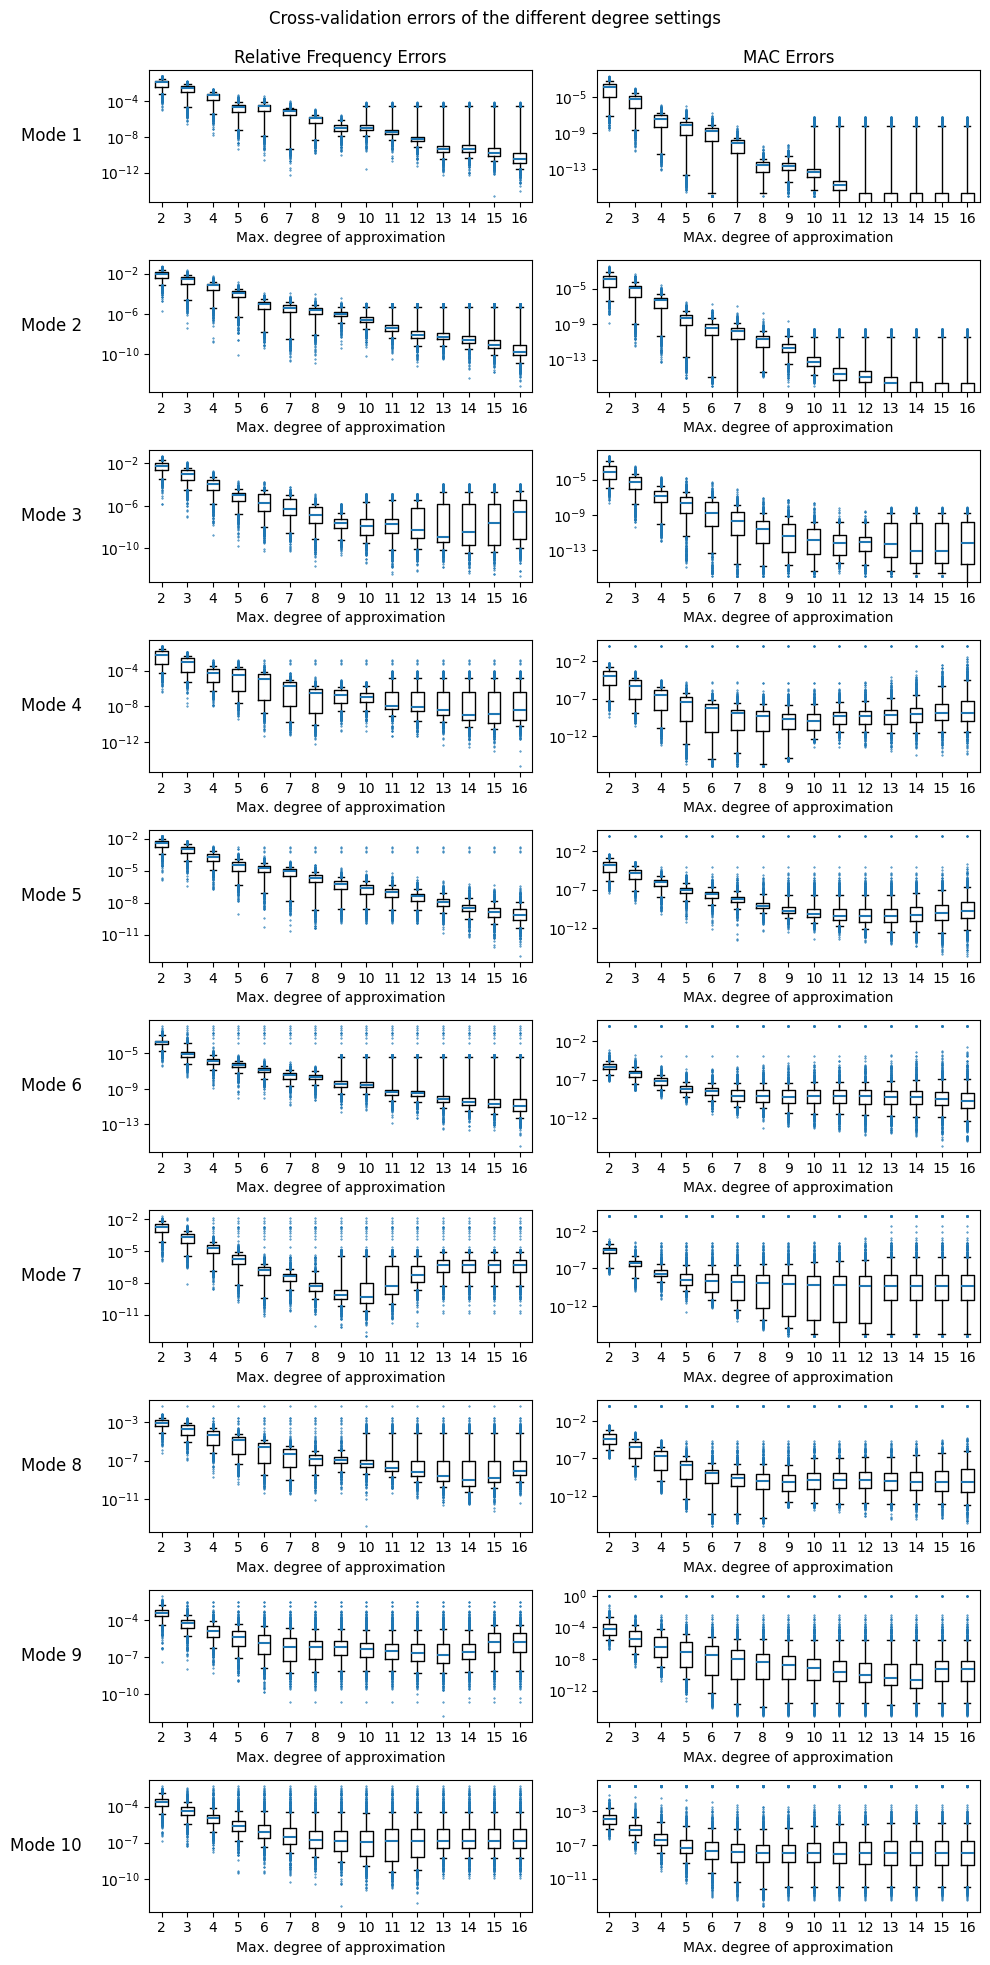

In [23]:
fig, ax = plt.subplots(10, 2, figsize=(10, 20))
flierprops = dict(marker='.', markerfacecolor='none', markersize=1,
                  linestyle='none', markeredgecolor='C0')
medianprops=dict(color ="C0", linewidth= 1.5)

degrees = np.arange(2, 17)

cols = ['Relative Frequency Errors', 'MAC Errors']
pad = 5


for axes, col in zip(ax[0], cols):
    axes.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for i, axes in enumerate(ax[:, 0]):
    axes.annotate('Mode {}'.format(i+1), xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),
                xycoords=axes.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')


for i in range(10):
    ax[i, 0].boxplot(total_freq_errors_degree[:, i, :], showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
    ax[i, 0].set_xlabel('Max. degree of approximation')
    ax[i, 0].set_xticklabels(degrees)
    ax[i, 0].set_yscale('log')

    ax[i, 1].boxplot(total_vect_errors_degree[:, i, :], showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
    ax[i, 1].set_xlabel('MAx. degree of approximation')
    ax[i, 1].set_xticklabels(degrees)
    ax[i, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Cross-validation errors of the different degree settings')

Using the results of the hyperparameter optimization process, we built and trained a model with settings `resolution=0.975`, `max_freq_degree=9` and `max_freq_degree=11`. Optimizing the classifier settings is not in the scope of this presentation.

The whole data is used for the training (~1.5 minute in this example).

In [24]:
model = mosaic.Mosaic(parameter_names, parameter_bounds, resolution=0.975, max_freq_degree=9, max_vect_degree=11, classification_method='svc', gamma='scale', kernel='poly', max_iter=-1, coef0=3, degree=5, probability=True)
model.fit(parameters, frequencies, eigenvectors, verbose=True)

Number of modes: 10
Mode 1 is trained
Mode 2 is trained
Mode 3 is trained
Mode 4 is trained
Mode 5 is trained
Mode 6 is trained
Mode 7 is trained
Mode 8 is trained
Mode 9 is trained
Mode 10 is trained


The cross-validation of the optimized model is done with the same settings as with the model in section 6 (~14 minutes in this example).

In [25]:
freq_errors, eigenvector_errors = mosaic.cross_validate(model, parameters, frequencies, eigenvectors, n_folds=9, shuffle=False, verbose=True)

Cross-validation started. The process may take a couple minutes
1/9 fold is done
2/9 folds are done
3/9 folds are done
4/9 folds are done
5/9 folds are done
6/9 folds are done
7/9 folds are done
8/9 folds are done
9/9 folds are done


The following plot shows the cross-validation errors of the optimized model. Comparing it to the plot in section 6, it is visible, how the optimal parameter settings effect the performance of the model.

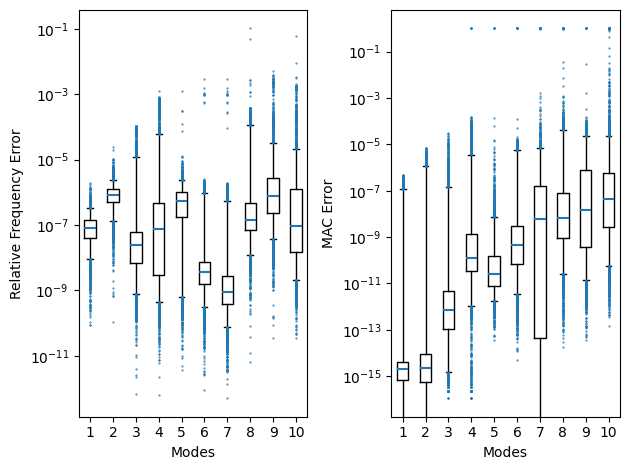

In [26]:
fig, axes = plt.subplots(1, 2)

flierprops = dict(marker='.', markerfacecolor='none', markersize=1,
                  linestyle='none', markeredgecolor='C0')
medianprops=dict(color ="C0", linewidth= 1.5)
axes[0].boxplot(freq_errors, showfliers = True, whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
axes[0].set_xlabel('Modes')
axes[0].set_ylabel('Relative Frequency Error')
axes[0].set_yscale('log')

axes[1].boxplot(eigenvector_errors, showfliers = True,  whis = (5, 95), flierprops=flierprops, medianprops=medianprops)
axes[1].set_xlabel('Modes')
axes[1].set_ylabel('MAC Error')
axes[1].set_yscale('log')

fig.tight_layout()

## 9. Exploration of the model

This section provides an insight of the inner nature of the MOSAIC model.

The `.get_number_of_classes()` method returns a list with the number of subdomains in each mode of the model.

In [27]:
n_classes = model.get_number_of_subdomains()
print('Number of subdomains in each mode: {}'.format(n_classes))

Number of subdomains in each mode: [ 2.  2.  2.  5.  2.  2.  5.  7. 12. 17.]


The `.get_class_labels()` method provides the results of the classifiers in each mode for the given `parameters`.

Using these labels, the parameter space division can be visualized. The following plot shows the cluster labels of the training data in a chosen mode in pairplots of the parameter space.

Text(0.5, 0.98, 'Parametric space division in mode 7')

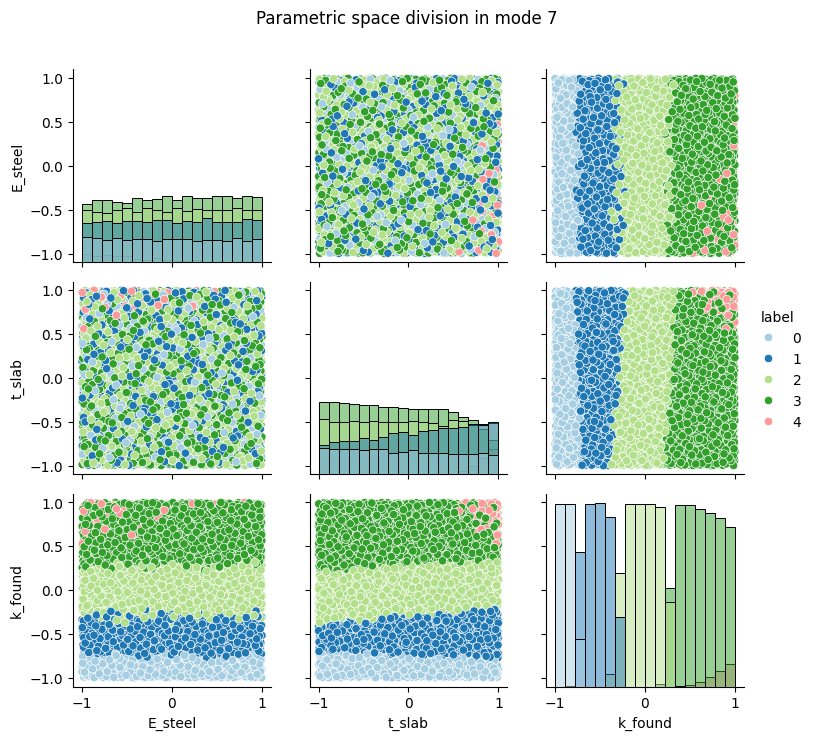

In [28]:
mode = 7

labels = model.get_class_labels(parameters)
n_clusters = len(np.unique(labels[:, mode-1]))

x_data = pd.DataFrame(parameters, columns=model.Q.param_names())
x_data.insert(3, "label", labels[:, mode-1], True)
x_data["label"] = x_data["label"].astype(int)

palette=sns.color_palette("Paired", n_clusters)
g = sns.PairGrid(x_data, hue="label", palette=palette)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Parametric space division in mode {}".format(mode))

Method `.get_reference_vectors()` returns the reference eigenvectors of each mode in a list of arrays.

The following plot shows the reference eigenvectors of the same mode and with the same colors as the previous one, to provide a deeper understanding of how the eigenvectors change in different points of the parametric space.

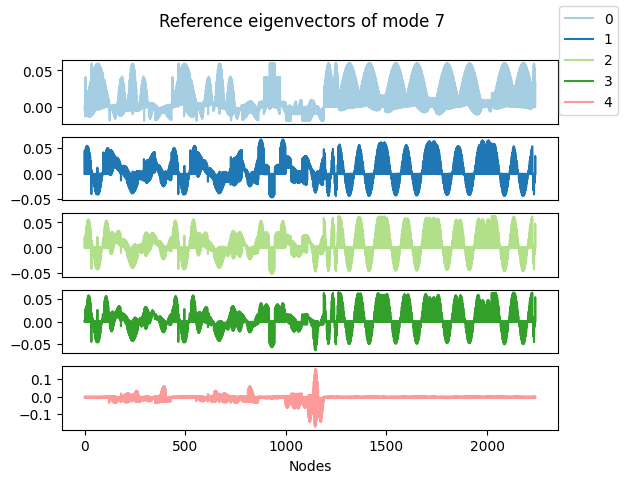

In [29]:
colors = iter(palette)

reference_eigenvectors = model.get_reference_vectors()[mode-1]

fig, ax = plt.subplots(n_clusters)
if n_clusters == 1:
    fig.suptitle("Reference eigenvector of mode {}".format(mode))
else:
    fig.suptitle("Reference eigenvectors of mode {}".format(mode))

if n_clusters == 1:
    ax.plot(reference_eigenvectors[0, :], color=next(colors))
else:
    for i in range(n_clusters):
        ax[i].plot(reference_eigenvectors[i, :], color=next(colors), label=i)
        if i != n_clusters-1:
            ax[i].set_xticklabels([])
            ax[i].set_xticks([])
    ax[i].set_xlabel("Nodes")
    fig.legend()

The method `.calculate_MAC_matrix()` returns a matrix of MAC-values calculated between rows of two arrays.

The MAC-matrix on the following plot shows the correlations between the reference eigenvectors in the chosen mode. Notice, that the correlations between the reference eigenvectors are lower than the chosen value of the `resolution`.

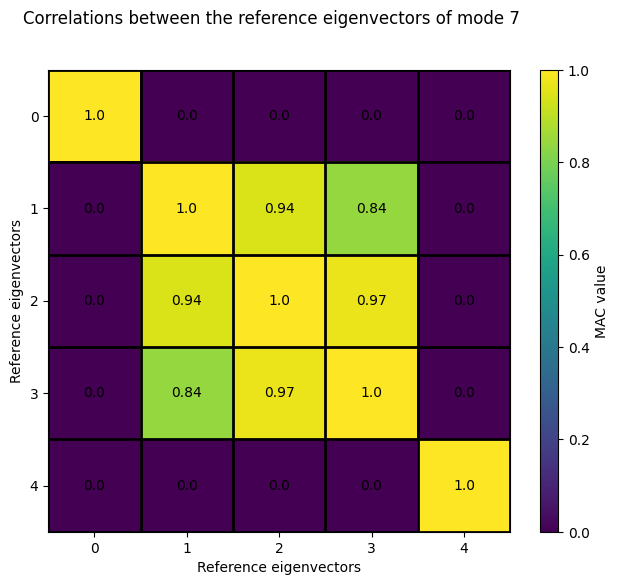

In [30]:
mac_matrix = mosaic.calculate_MAC_matrix(reference_eigenvectors, reference_eigenvectors)

fig = plt.figure(figsize=(6,6))
fig.suptitle("Correlations between the reference eigenvectors of mode {}".format(mode))
im = plt.imshow(mac_matrix, interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

ax.set_xticks(np.arange(0, n_clusters, 1))
ax.set_yticks(np.arange(0, n_clusters, 1))

ax.set_xlabel("Reference eigenvectors")
ax.set_ylabel("Reference eigenvectors")

ax.set_xticklabels(np.arange(0, n_clusters, 1))
ax.set_yticklabels(np.arange(0, n_clusters, 1))

ax.set_xticks(np.arange(-.5, n_clusters, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_clusters, 1), minor=True)

ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
ax.tick_params(which='minor', bottom=False, left=False)

for i in range(n_clusters):
    for j in range(n_clusters):
        text = ax.text(j, i, round(mac_matrix[i, j], 2),
                    ha="center", va="center", color="k")
cax=fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(im, cax = cax)
cbar.set_label("MAC value")

## 10. Saving and loading

Using the library it is possible to save and load previously created or trained models using `pickle`. These methods could improve time efficiency, because a trained and saved model can be used rigth after loading it, no need for retrain.

The model is saved in a custom '.msic' file and it is the reqired format for loading it.

The `.save()` method needs an existing Mosaic model, a filename and a folder path (strings).

In [31]:
mosaic.save(model, 'example', '')

The file path of an existing '.msic' file is needed for loading a model in `.load()`.

In [32]:
loaded_model = mosaic.load('example.msic')